In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Завантаження даних
btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'
eth_file = '../knn/Ethereum_01.12.2018-28.02.2025_historical_data_coinmarketcap.csv'

df_btc = pd.read_csv(btc_file, sep=';')
df_eth = pd.read_csv(eth_file, sep=';')

# Підготовка даних з окремими скейлерами
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_df = df_btc.copy()

In [3]:
columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
for col in columns_to_drop:
    if col in scaled_df.columns:
        scaled_df.drop(columns=[col], inplace=True)

# Встановлюємо timestamp як індекс
if 'timestamp' in scaled_df.columns:
    scaled_df = scaled_df.set_index('timestamp')

# Масштабування features (все окрім close)
feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
target_column = 'close'

# Перевіряємо, чи всі колонки існують
available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
print(f"Доступні колонки для features: {available_feature_cols}")

if target_column not in scaled_df.columns:
    print(f"Помилка: колонка '{target_column}' не знайдена!")
    exit()

# Масштабування
scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

print("Структура даних:")
print(scaled_df.head())
print(f"Shape: {scaled_df.shape}")

Доступні колонки для features: ['open', 'high', 'low', 'volume', 'marketCap']
Структура даних:
                          name      open      high       low     close  \
timestamp                                                                
2025-03-19T23:59:59.999Z  2781  0.577186  0.616542  0.595481  0.651858   
2025-03-18T23:59:59.999Z  2781  0.601675  0.565420  0.570740  0.577225   
2025-03-17T23:59:59.999Z  2781  0.574615  0.576695  0.594100  0.601717   
2025-03-16T23:59:59.999Z  2781  0.606324  0.582358  0.585657  0.574720   
2025-03-15T23:59:59.999Z  2781  0.599738  0.575781  0.614528  0.606543   

                            volume  marketCap  
timestamp                                      
2025-03-19T23:59:59.999Z  0.179920   0.657170  
2025-03-18T23:59:59.999Z  0.102163   0.582669  
2025-03-17T23:59:59.999Z  0.109318   0.606958  
2025-03-16T23:59:59.999Z  0.082319   0.580049  
2025-03-15T23:59:59.999Z  0.027212   0.611688  
Shape: (399, 7)


In [4]:
def prepare_data(df, window_size=5):
    """
    Підготовка даних для навчання з вікном часу
    """
    X, y = [], []
    feature_cols = [col for col in df.columns if col != 'close']
    
    for i in range(len(df) - window_size):
        # Беремо features за window_size днів
        features = df[feature_cols].iloc[i:i+window_size].values
        # Target - ціна закриття наступного дня
        target = df['close'].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [5]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2=None, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_size1))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        if hidden_size2:
            layers.append(nn.Linear(hidden_size1, hidden_size2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_size2, 1))
        else:
            layers.append(nn.Linear(hidden_size1, 1))
            
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                             target_scaler, results_dict, epochs=100, lr=0.001):
    """
    Навчання та оцінка PyTorch моделі з збереженням найкращої
    """
    print(f"Training {model_name}...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Конвертація в тензори
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Навчання
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    # Прогнозування
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()
    
    # Зворотнє масштабування
    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Метрики
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    
    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,  # Зберігаємо модель
        'X_test': X_test,
        'y_test': y_test
    }
    
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)
    
    return model

In [7]:
# Основний код для експериментів
results = {}

# Параметри для експериментів
window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("🚀 Початок експериментів з MLP моделями")
print("=" * 60)

# Основний цикл експериментів
experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


🚀 Початок експериментів з MLP моделями


In [8]:
for window_size in window_sizes:
    print(f"\n📊 Window size: {window_size}")
    
    # Підготовка даних для поточного window_size
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = X_train.shape[1]
    
    for hidden_config in hidden_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                experiment_count += 1
                
                # Створення моделі
                if len(hidden_config) == 1:
                    model = MLPModel(input_size=input_size, 
                                   hidden_size1=hidden_config[0])
                    model_name = f"MLP_w{window_size}_h{hidden_config[0]}_lr{lr}_e{epochs}"
                else:
                    model = MLPModel(input_size=input_size, 
                                   hidden_size1=hidden_config[0],
                                   hidden_size2=hidden_config[1])
                    model_name = f"MLP_w{window_size}_h{hidden_config[0]}-{hidden_config[1]}_lr{lr}_e{epochs}"
                
                print(f"\n[{experiment_count}/{total_experiments}] {model_name}")
                
                # Навчання моделі
                run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                              target_scaler, results, epochs=epochs, lr=lr)

# Результати
print("\n" + "=" * 80)
print("📈 ПІДСУМОК РЕЗУЛЬТАТІВ ВСІХ ЕКСПЕРИМЕНТІВ")
print("=" * 80)



📊 Window size: 5
Training set shape: (315, 30)
Test set shape: (79, 30)

[1/90] MLP_w5_h64_lr0.001_e50
Training MLP_w5_h64_lr0.001_e50...
Epoch 20/50, Loss: 13695.378906
Epoch 40/50, Loss: 6120.659180
RMSE: 41949.9259, MAE: 41571.3770
--------------------------------------------------

[2/90] MLP_w5_h64_lr0.001_e100
Training MLP_w5_h64_lr0.001_e100...
Epoch 20/100, Loss: 37014.515625
Epoch 40/100, Loss: 22667.298828
Epoch 60/100, Loss: 19036.884766
Epoch 80/100, Loss: 14938.347656
Epoch 100/100, Loss: 14728.198242
RMSE: 133155.1592, MAE: 133067.8220
--------------------------------------------------

[3/90] MLP_w5_h64_lr0.001_e1000
Training MLP_w5_h64_lr0.001_e1000...
Epoch 20/1000, Loss: 14291.325195
Epoch 40/1000, Loss: 11183.688477
Epoch 60/1000, Loss: 9621.759766
Epoch 80/1000, Loss: 6351.907715
Epoch 100/1000, Loss: 5282.889160
Epoch 120/1000, Loss: 3508.081055
Epoch 140/1000, Loss: 2954.470947
Epoch 160/1000, Loss: 2369.343750
Epoch 180/1000, Loss: 1962.488281
Epoch 200/1000, Lo

In [9]:
# Сортування за RMSE
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

# Найкраща модель
best_model = sorted_results[0]
print(f"\n🏆 НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

# Аналіз результатів по window_size
print(f"\n📊 АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
MLP_w10_h128_lr0.001_e1000               5120.4260  3897.4259  0.029645    
MLP_w10_h64_lr0.001_e1000                5778.5735  4417.3472  0.263700    
MLP_w10_h64-32_lr0.01_e1000              6122.0231  4741.5320  0.490918    
MLP_w15_h256-128_lr0.01_e1000            6160.1786  4843.4692  0.195202    
MLP_w5_h128-64_lr0.01_e1000              6160.8503  4960.4735  0.144578    
MLP_w10_h128-64_lr0.001_e1000            6275.3854  5198.9161  0.722575    
MLP_w15_h64-32_lr0.001_e1000             6460.2734  4718.6534  2.568344    
MLP_w15_h64_lr0.001_e1000                6473.0795  4860.9896  0.038717    
MLP_w10_h128-64_lr0.01_e1000             6516.6280  4770.8966  0.182295    
MLP_w10_h128-64_lr0.01_e100              6643.3627  4826.1244  7.717589    
MLP_w15_h256-128_lr0.001_e1000           6667.6704  4811.3048  0.869344    
MLP_w5_

In [10]:
# def run_complete_analysis(df, feature_scaler, target_scaler, best_model, 
#                          X_test, y_test, model_name):
#     """
#     Запуск повного аналізу моделі
#     """
#     print("🚀 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ")
#     print("=" * 60)
    
#     # Ініціалізація аналізатора
#     analyzer = ModelAnalyzer(df, feature_scaler, target_scaler)
    
#     # 1. Аналіз кореляцій
#     correlation_matrix = analyzer.analyze_correlations()
    
#     # 2. Розподіл ознак
#     analyzer.create_feature_distributions()
    
#     # 3. Детальний аналіз найкращої моделі
#     # results = analyzer.analyze_best_model(best_model, X_test, y_test, model_name)
    
#     # 4. Аналіз важливості ознак
#     feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
#     analyzer.create_feature_importance_analysis(best_model, X_test, feature_names)
    
#     print(f"\n✅ АНАЛІЗ ЗАВЕРШЕНО!")
#     print("=" * 60)
    
#     return analyzer, results

# # Приклад використання (додайте це до основного коду):

# # Після навчання всіх моделей та визначення найкращої:
# best_model_name = sorted_results[0][0]  # Назва найкращої моделі
# # Тут потрібно зберегти саму модель під час навчання та передати її сюда

# # Запуск аналізу
# analyzer, analysis_results = run_complete_analysis(
#     df=scaled_df,
#     feature_scaler=feature_scaler, 
#     target_scaler=target_scaler,
#     best_model=best_model[0],  
#     X_test=X_test,
#     y_test=y_test,
#     model_name=best_model_name
# )



🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
🚀 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
🔍 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


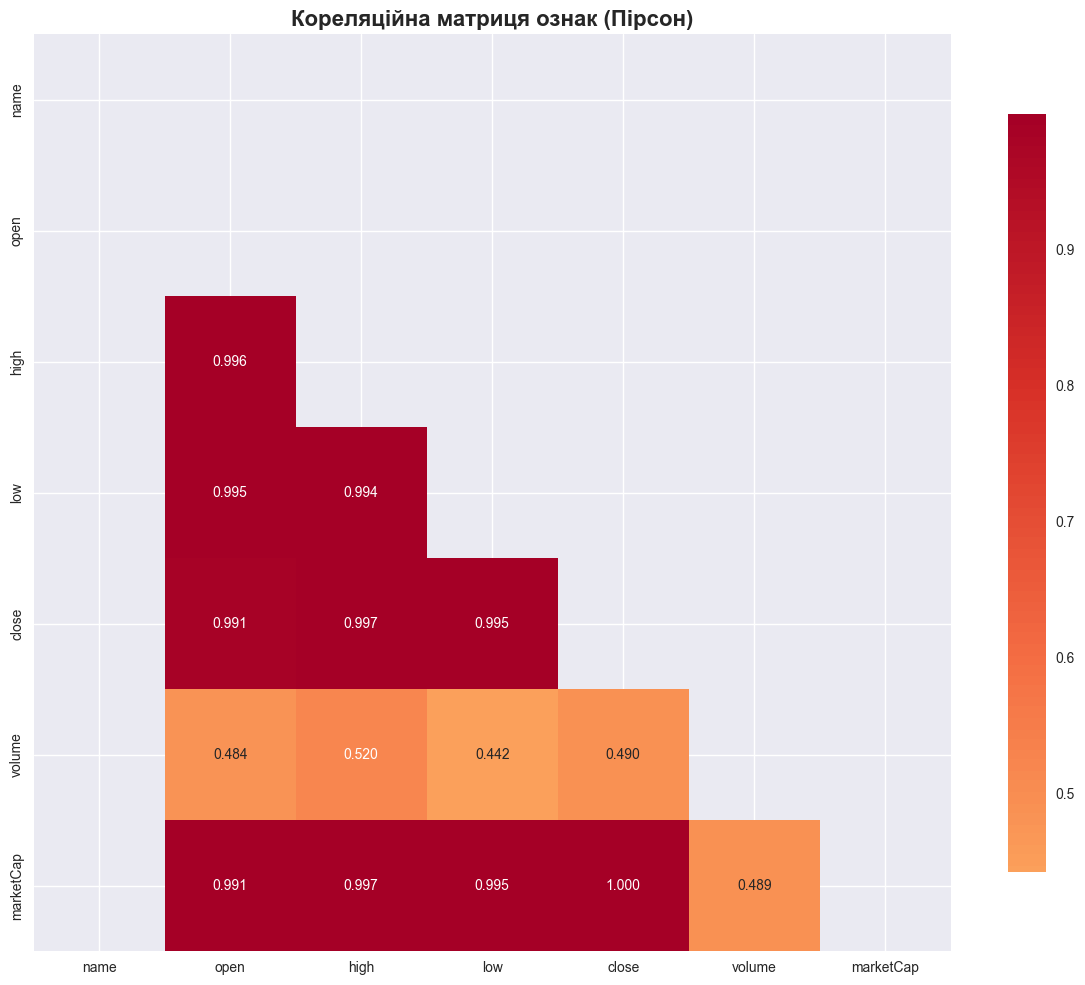


 Найсильніші кореляції:
name ↔ open: nan
name ↔ high: nan
name ↔ low: nan
name ↔ close: nan
name ↔ volume: nan
name ↔ marketCap: nan
open ↔ high: 0.996
open ↔ low: 0.995
open ↔ close: 0.991
open ↔ volume: 0.484
open ↔ marketCap: 0.991
high ↔ low: 0.994
high ↔ close: 0.997
high ↔ volume: 0.520
high ↔ marketCap: 0.997
low ↔ close: 0.995
low ↔ volume: 0.442
low ↔ marketCap: 0.995
close ↔ volume: 0.490
close ↔ marketCap: 1.000
volume ↔ marketCap: 0.489
 1. close        ↔ marketCap   :  1.000
 2. high         ↔ marketCap   :  0.997
 3. high         ↔ close       :  0.997
 4. open         ↔ high        :  0.996
 5. low          ↔ marketCap   :  0.995
 6. low          ↔ close       :  0.995
 7. open         ↔ low         :  0.995
 8. high         ↔ low         :  0.994
 9. open         ↔ marketCap   :  0.991
10. open         ↔ close       :  0.991

📈 РОЗПОДІЛ ОЗНАК


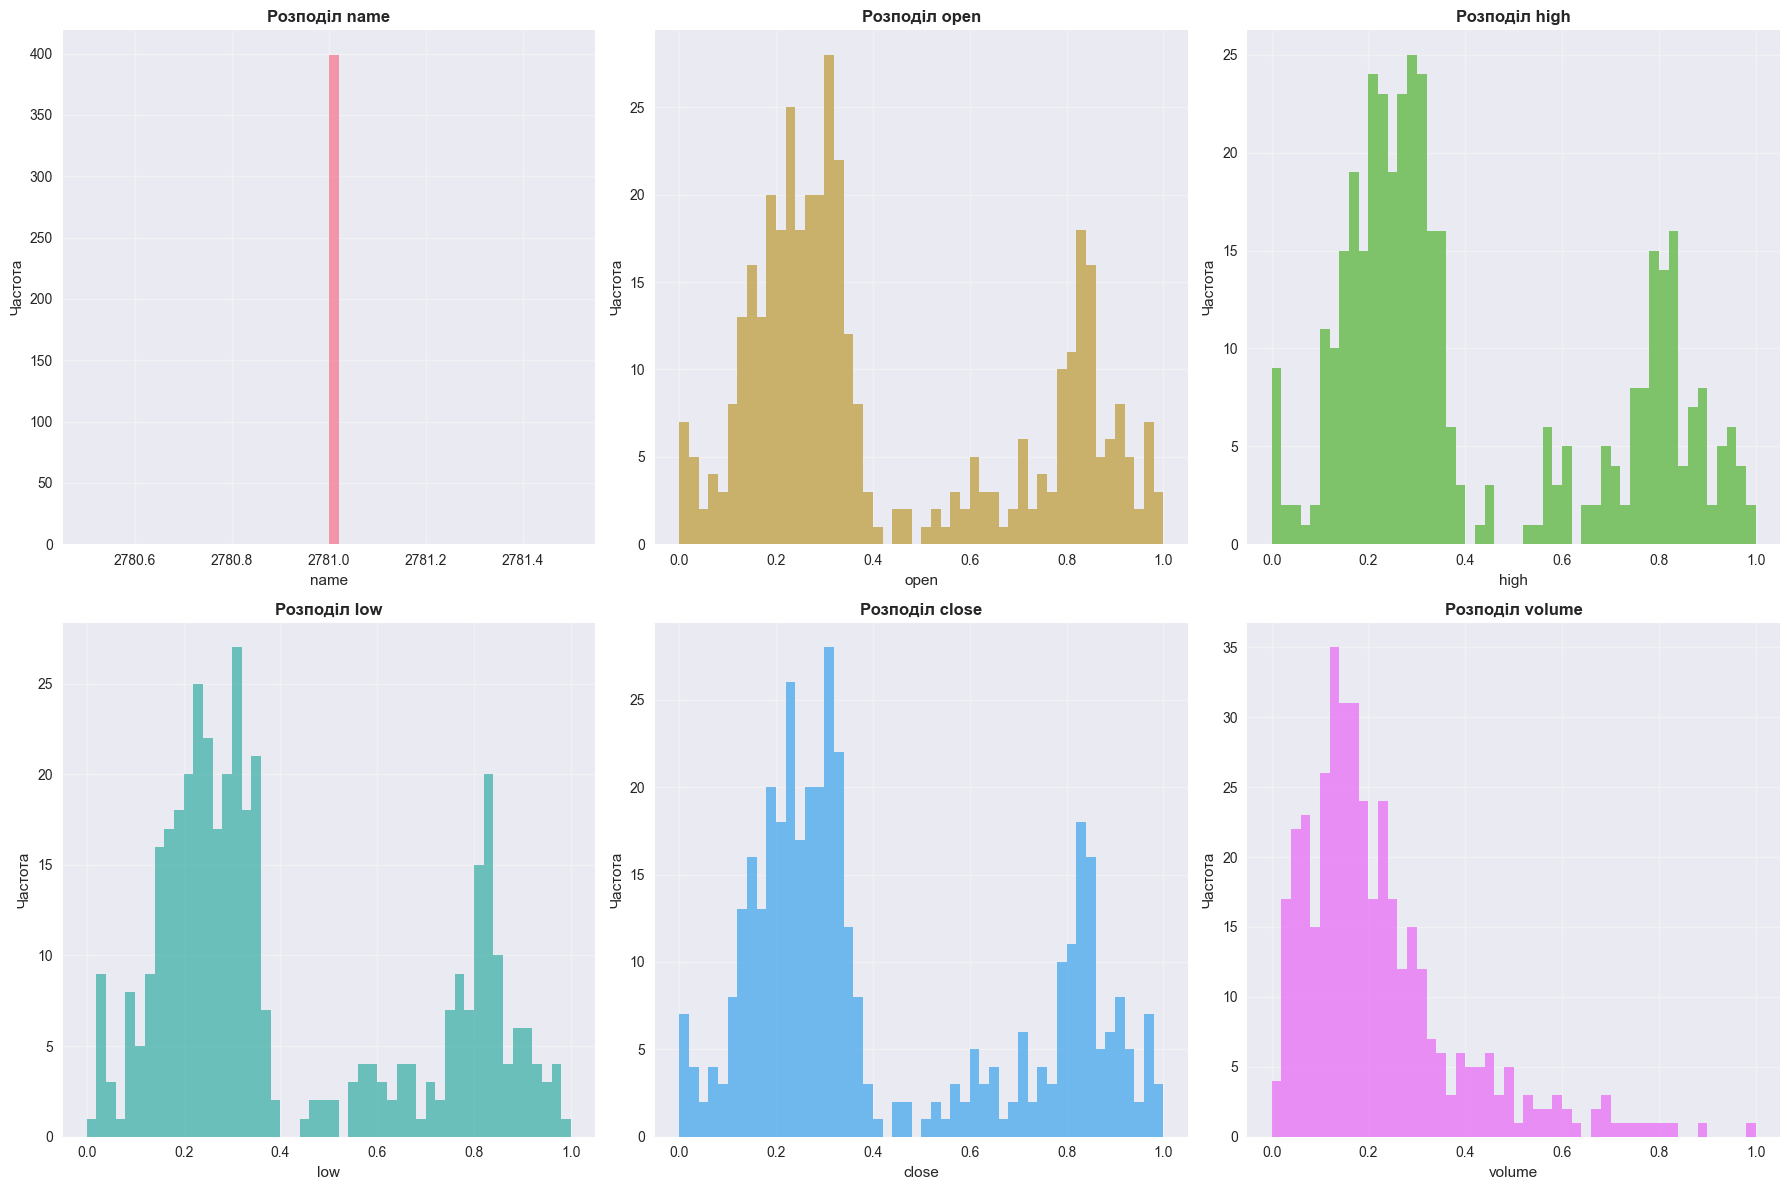


🏆 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: MLP_w10_h128_lr0.001_e1000
📊 МЕТРИКИ РЕГРЕСІЇ:
RMSE (Root Mean Square Error): 5120.4260
MAE (Mean Absolute Error): 3897.4259
MAPE (Mean Absolute Percentage Error): 6.59%
R² Score: 0.3008
Explained Variance Score: 0.5939


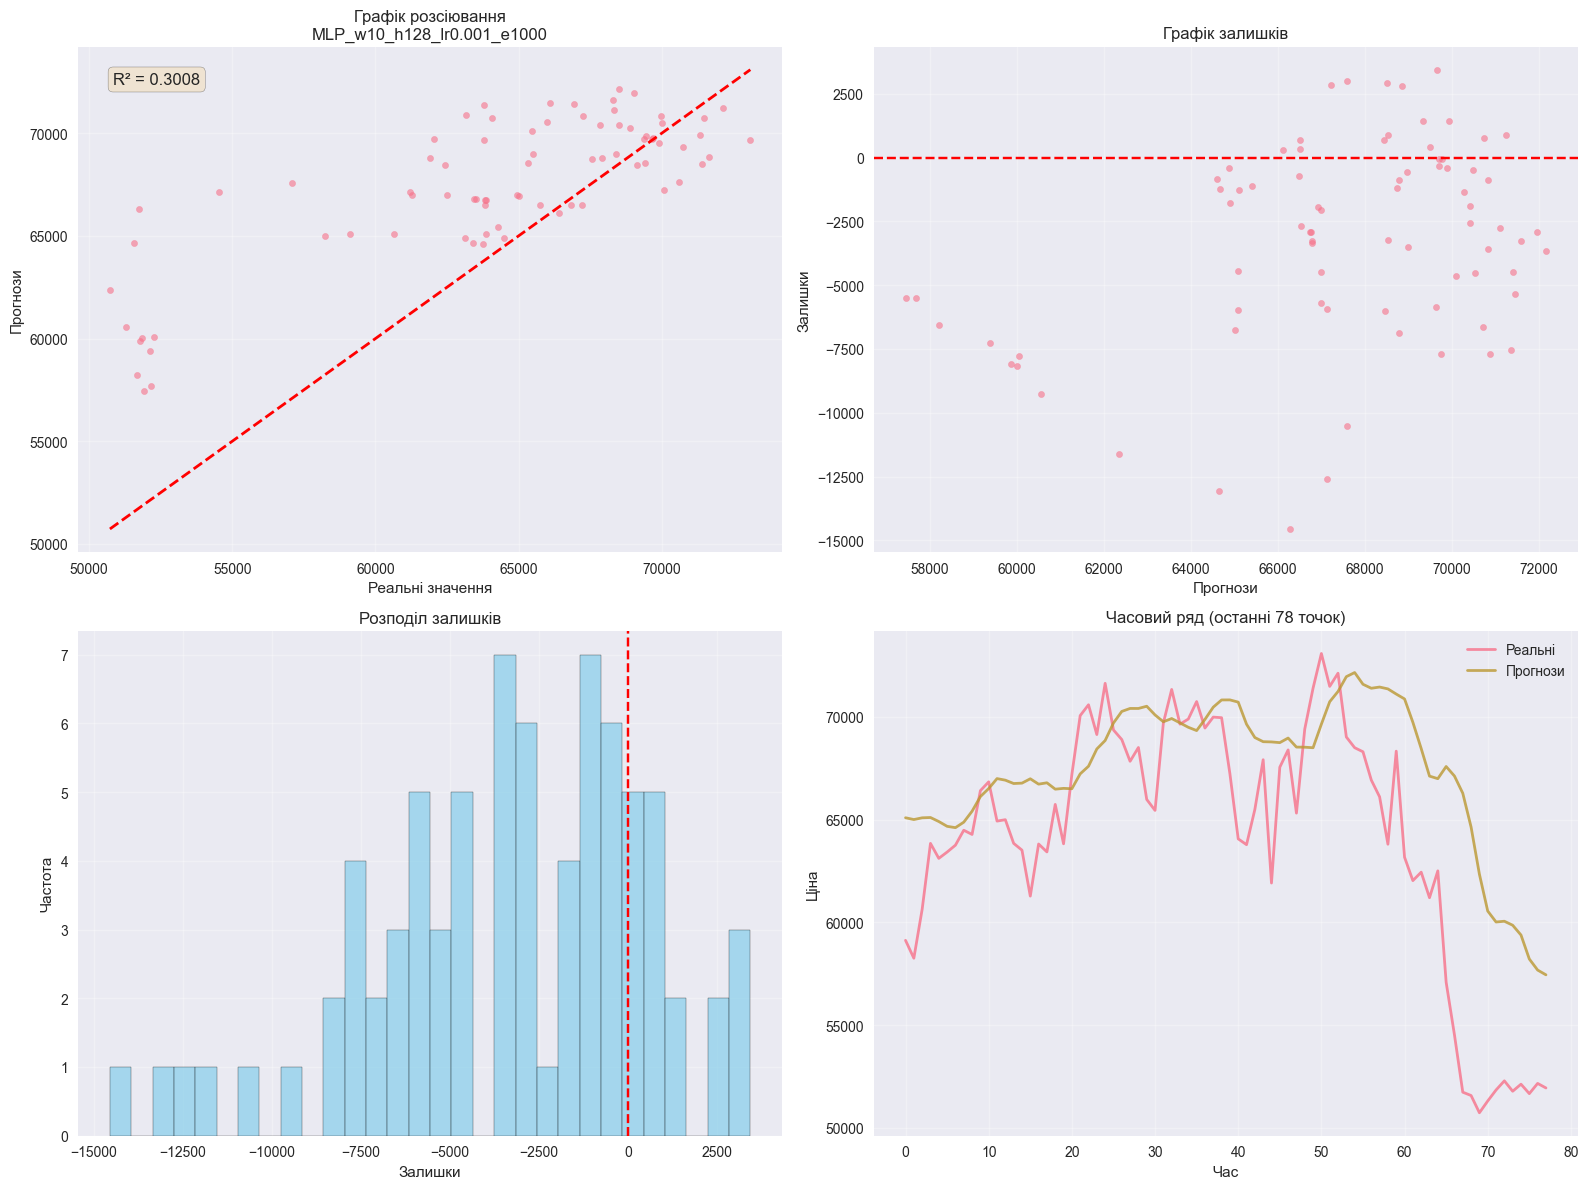


🎯 КЛАСИФІКАЦІЙНІ МЕТРИКИ (Напрямок руху ціни):
Класи: 0 = Спадання, 1 = Зростання
Accuracy: 0.4675
Precision: 0.4646
Recall: 0.4675
F1-Score: 0.4654

📋 Детальний класифікаційний звіт:
              precision    recall  f1-score   support

    Спадання       0.50      0.54      0.52        41
   Зростання       0.42      0.39      0.41        36

    accuracy                           0.47        77
   macro avg       0.46      0.46      0.46        77
weighted avg       0.46      0.47      0.47        77



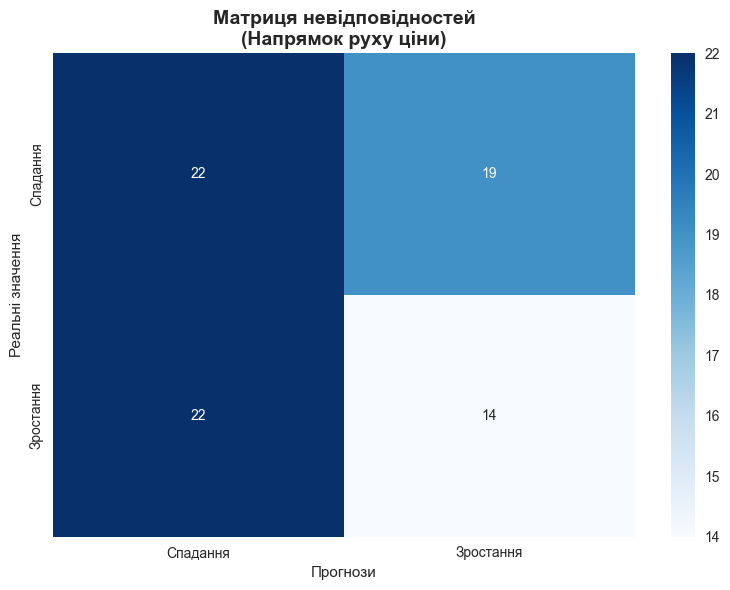


📊 Інтерпретація матриці невідповідностей:
True Negatives (правильно передбачені спадання): 22
False Positives (помилково передбачені зростання): 19
False Negatives (пропущені зростання): 22
True Positives (правильно передбачені зростання): 14

📊 ТАБЛИЦЯ ПОРІВНЯННЯ МЕТРИК:
Метрика      Значення   Опис                                    
-----------------------------------------------------------------
Accuracy     0.4675     Частка правильних прогнозів             
Precision    0.4646     Частка правильних позитивних прогнозів  
Recall       0.4675     Частка знайдених позитивних випадків    
F1-Score     0.4654     Гармонічне середнє Precision і Recall   


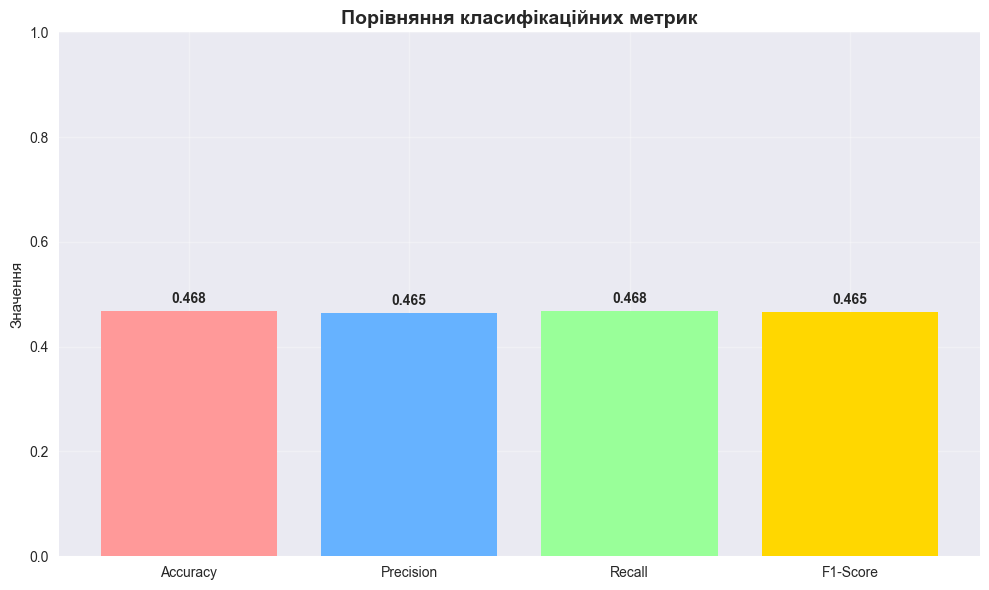


🔍 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
📊 Статистика параметрів моделі:
Загальна кількість параметрів: 7,937
Навчальні параметри: 7,937

📈 Статистика вхідних ознак:
       Feature       Mean     Std        Min        Max
0    Feature_0  2781.0000  0.0000  2781.0000  2781.0000
1    Feature_1     0.2628  0.0785     0.0150     0.4032
2    Feature_2     0.2673  0.0723     0.0078     0.3862
3    Feature_3     0.2568  0.0732     0.0322     0.3955
4    Feature_4     0.2076  0.1263     0.0283     0.6669
5    Feature_5     0.2628  0.0724     0.0179     0.3977
6    Feature_6  2781.0000  0.0000  2781.0000  2781.0000
7    Feature_7     0.2605  0.0835     0.0000     0.4032
8    Feature_8     0.2650  0.0775     0.0032     0.3862
9    Feature_9     0.2545  0.0774     0.0261     0.3955
10  Feature_10     0.2077  0.1262     0.0286     0.6669
11  Feature_11     0.2605  0.0773     0.0149     0.3977
12  Feature_12  2781.0000  0.0000  2781.0000  2781.0000
13  Feature_13     0.2583  0.0877     0.0000     0.4032
14  Feat

In [11]:
# ЗАПУСК ПОВНОГО АНАЛІЗУ
print("\n" + "🔍" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("🔍" * 20)

best_model_name = sorted_results[0][0]

# Імпорт аналізатора (переконайтесь, що попередній код доступний)
from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]  # Назва найкращої моделі
model_results = best_model[1]  # Словник з результатами
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

# Тепер використовуйте actual_model замість best_model
analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)